In [15]:
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.utils import unbatch_edge_index
from sklearn.metrics._classification import accuracy_score, f1_score, precision_score, recall_score
from pair_prediction.model.utils import get_negative_edges


In [16]:
with open('../outputs/rinalmo_ts1/results.pkl', 'rb') as f:
    results = pickle.load(f)

In [17]:
extracted_data = {
    'ids': [],
    'sequences': [],
    'inference_edge_index': [],
    'probabilities': [],
    'labels': [],
    'edge_index': [],
}

for result in results:
    data = result['data']
    extracted_data['ids'].extend(data.id)
    extracted_data['sequences'].extend(data.seq)
    extracted_data['edge_index'].extend([x.numpy() for x in unbatch_edge_index(data.edge_index, data.batch)])

    edge_mask = np.concatenate(data.edge_type) == 'non-canonical'
    pos_edge_index_batch = data.edge_index[:, edge_mask]

    pos_edge_index = unbatch_edge_index(pos_edge_index_batch, data.batch)
    pos_probabilities = result['probabilities'][:pos_edge_index_batch.size(1)]
    pos_labels = result['labels'][:pos_edge_index_batch.size(1)]

    neg_edge_index = get_negative_edges(data, validation=True)
    neg_edge_index = unbatch_edge_index(neg_edge_index, data.batch)
    neg_probabilities = result['probabilities'][pos_edge_index_batch.size(1):]
    neg_labels = result['labels'][pos_edge_index_batch.size(1):]

    i = 0
    for pos, neg in zip(pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos, neg], dim=1).numpy()
        probabilities = torch.cat([pos_probabilities[i:i + pos.size(1)], neg_probabilities[i:i + neg.size(1)]]).numpy()
        labels = torch.cat([pos_labels[i:i + pos.size(1)], neg_labels[i:i + neg.size(1)]]).numpy()
        extracted_data['inference_edge_index'].append(edge_index)
        extracted_data['probabilities'].append(probabilities)
        extracted_data['labels'].append(labels)


In [18]:
df = pd.DataFrame(extracted_data)

ValueError: All arrays must be of the same length

In [5]:
# Optimize prediction threshold for F1 score
def optimize_threshold(probabilities, labels):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (probabilities > threshold).astype(int)
        f1_scores.append(f1_score(labels, y_pred))
    
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold, max(f1_scores)

# Calculate general optimized threshold
general_threshold, general_f1 = optimize_threshold(
    np.concatenate(df['probabilities'].values),
    np.concatenate(df['labels'].values)
)
print(f"General optimized threshold: {general_threshold}, F1 score: {general_f1}")

General optimized threshold: 0.5353535353535354, F1 score: 0.6458110694137237


In [6]:
def get_metrics(row):
    y_true = row['labels']
    y_pred = (row['probabilities'] > general_threshold).astype(int)
    return {
        'f1_score': f1_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred),
    }

df_metrics = df.apply(get_metrics, axis=1, result_type='expand')
df = pd.concat([df, df_metrics], axis=1)

/home/inf141171/anaconda3/envs/masters/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/inf141171/anaconda3/envs/masters/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/inf141171/anaconda3/envs/masters/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/inf141171/anaconda3/envs/masters/lib/

<Axes: >

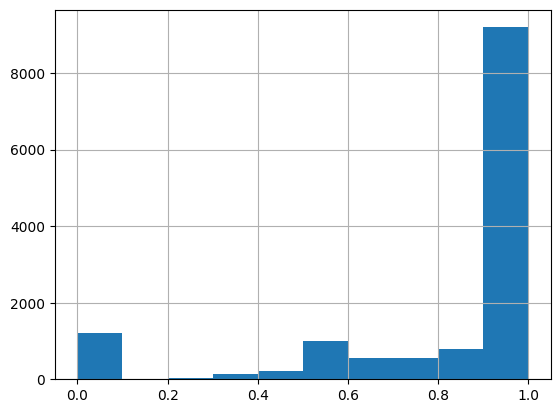

In [7]:
df.precision.hist()